In [1]:
!pip install gsw -q

# Dask start

In [2]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:46369")

In [3]:
import sys
sys.path.insert(1, '..')

In [4]:
import s3fs
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.gridspec import GridSpec
import gsw
import gcm_filters
from xhistogram.xarray import histogram
import eos_module
from dask import compute
import pandas as pd
import cartopy.crs as ccrs
import xgcm
import xesmf as xe

In [5]:
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

# Plotting params

In [6]:
#%matplotlib widget
%matplotlib inline

In [7]:
line_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', '#1f77b4']

In [8]:
cmaps_list = ['Blues', 'Oranges', 'Greens', 'Reds']

## Histograms routines

In [9]:
def compute_2D_histogram(dataSet, var1, var2, nb_of_bins, bins=None) :
    if bins is None :
        bins1 = np.linspace(dataSet[var1].min(), dataSet[var1].max(), nb_of_bins)
        bins2 = np.linspace(dataSet[var2].min(), dataSet[var2].max(), nb_of_bins)
    else :
        bins1 = bins[0]; bins2 = bins[1]
    area_weigths = xr.DataArray((dataSet.e1t * dataSet.e2t), dims=['y','x'])
    #area_weigths.fillna(0.)
    normalized_weights = (area_weigths/area_weigths.sum(skipna=True)).fillna(0.)
    hist = histogram(dataSet[var1].fillna(0), dataSet[var2].fillna(0), bins=[bins1, bins2], weights=normalized_weights, density=False)
    norm_hist = (hist/hist.sum(skipna=True)).fillna(0.)
    return norm_hist

In [10]:
min_hist = 1e-5
max_hist = 0.5
log_norm=colors.LogNorm(vmin=min_hist, vmax=max_hist)

# plotting routine
def margin_hist(data, color_index, x_bins, y_bins, ax_histx, ax_histy, ax_big):
    hist_joint = ax_big.pcolormesh(data[x_bins],data[y_bins], data.T, norm=log_norm, cmap=cmaps_list[color_index], shading='auto', alpha=0.75)
    if 'slope' in data.attrs :
        ax_big.plot(data[x_bins], data.attrs['slope']*data[x_bins]+data.attrs['increment'], color=line_colors[color_index])
    
    margin_hist_x = data.sum(dim=y_bins)
    ax_histx.plot(data[x_bins],margin_hist_x, color=line_colors[color_index])
    ax_histx.set(yscale='log', ylim=[min_hist, max_hist])
    ax_histx.tick_params(labelleft=False, labelbottom=False)    
    
    margin_hist_y = data.sum(dim=x_bins)
    ax_histy.plot(margin_hist_y,data[y_bins], color=line_colors[color_index])
    ax_histy.set(xscale='log', xlim=[min_hist, max_hist])
    ax_histy.tick_params(labelleft=False, labelbottom=False)     
    
    return hist_joint

# Load data

Choose cases

In [11]:
data=[dict() for i in range(6)]

In [12]:
data[0] = dict({'region' : '1', 'season' : 'fma', 'label' : 'GULFSTR wint'})
data[1] = dict({'region' : '1', 'season' : 'aso', 'label' : 'GULFSTR sum'})
data[2] = dict({'region' : '2', 'season' : 'fma', 'label' : 'MIDATL wint'})
data[3] = dict({'region' : '2', 'season' : 'aso', 'label' : 'MIDATL sum'})
data[4] = dict({'region' : '3', 'season' : 'fma', 'label' : 'WESTMED wint'})
data[5] = dict({'region' : '3', 'season' : 'aso', 'label' : 'WESTMED sum'})

In [13]:
from validate_catalog import all_params
params_dict, cat = all_params()

In [14]:
x_slice = slice(0,-1)
y_slice = slice(0,-1)

data_slice = dict(time_counter=slice(0,-1,10),y=y_slice,x=x_slice) 
coord_slice = dict(y=y_slice,x=x_slice)

In [15]:
chunk_dict = {'x' : -1, 'y' : -1, 'time_counter' : 3, 'deptht' : 20, 'depthu' : 20, 'depthv' : 20}

In [16]:
%%time
for i in range(len(data)) :
    #current_set = xr.open_mfdataset('/Users/ana/data/eNATL60_extractions/region'+data[i]['region']+'_'+data[i]['season']+'.nc', parallel=True).chunk({'time_counter' : nb_of_time_chunks, 'x' : -1, 'y' : -1}).\
    current_set = cat.eNATL60(region=data[i]['region'],datatype='interior_daily', season=data[i]['season']).to_dask()
    #current_set = current_set.resample({'time_counter' : resampling_avg_period}, closed='right', label='right').mean()
    current_set = current_set.isel(data_slice)
    current_set = current_set.chunk(chunk_dict)
    data[i]['HR'] = current_set

CPU times: user 1.28 s, sys: 52.2 ms, total: 1.33 s
Wall time: 3.8 s


In [17]:
data[0]['HR']

<xarray.Dataset>
Dimensions:       (y: 762, x: 610, deptht: 107, depthu: 107, depthv: 107,
                   depthw: 107, time_counter: 9)
Coordinates: (12/18)
    depth         (y, x) float32 dask.array<chunksize=(762, 610), meta=np.ndarray>
  * deptht        (deptht) float32 0.4805 1.559 2.794 ... 968.4 985.3 1.002e+03
  * depthu        (depthu) float32 0.4805 1.559 2.794 ... 968.4 985.3 1.002e+03
  * depthv        (depthv) float32 0.4805 1.559 2.794 ... 968.4 985.3 1.002e+03
  * depthw        (depthw) float32 0.0 1.0 2.157 3.471 ... 960.0 976.9 993.8
    e1f           (y, x) float64 dask.array<chunksize=(762, 610), meta=np.ndarray>
    ...            ...
    e2v           (y, x) float64 dask.array<chunksize=(762, 610), meta=np.ndarray>
    lat           (y, x) float32 dask.array<chunksize=(762, 610), meta=np.ndarray>
    lon           (y, x) float32 dask.array<chunksize=(762, 610), meta=np.ndarray>
    nav_lat       (y, x) float32 dask.array<chunksize=(762, 610), meta=np.ndarray>
    nav_lon       (y, x) float32 dask.array<chunksize=(762, 610), meta=np.ndarray>
  * time_counter  (time_counter) datetime64[ns] 2010-02-01 ... 2010-04-22
Dimensions without coordinates: y, x
Data variables: (12/13)
    e3t_0         (deptht, y, x) float64 dask.array<chunksize=(20, 762, 610), meta=np.ndarray>
    e3u_0         (depthu, y, x) float64 dask.array<chunksize=(20, 762, 610), meta=np.ndarray>
    e3v_0         (depthv, y, x) float64 dask.array<chunksize=(20, 762, 610), meta=np.ndarray>
    e3w_0         (depthw, y, x) float64 dask.array<chunksize=(107, 762, 610), meta=np.ndarray>
    fmask         (deptht, y, x) int8 dask.array<chunksize=(20, 762, 610), meta=np.ndarray>
    tmask         (deptht, y, x) int8 dask.array<chunksize=(20, 762, 610), meta=np.ndarray>
    ...            ...
    vmask         (depthv, y, x) int8 dask.array<chunksize=(20, 762, 610), meta=np.ndarray>
    vomecrty      (time_counter, depthv, y, x) float32 dask.array<chunksize=(3, 20, 762, 610), meta=np.ndarray>
    vosaline      (time_counter, deptht, y, x) float32 dask.array<chunksize=(3, 20, 762, 610), meta=np.ndarray>
    votemper      (time_counter, deptht, y, x) float32 dask.array<chunksize=(3, 20, 762, 610), meta=np.ndarray>
    vovecrtz      (time_counter, depthw, y, x) float32 dask.array<chunksize=(3, 107, 762, 610), meta=np.ndarray>
    vozocrtx      (time_counter, depthu, y, x) float32 dask.array<chunksize=(3, 20, 762, 610), meta=np.ndarray>

# Grid metrics

In [18]:
metrics = {
    ('X',): ['e1t', 'e1u', 'e1v'], # X distances
    ('Y',): ['e2t', 'e2u', 'e2v'], # Y distances
    ('Z',): ['e3t', 'e3u', 'e3v', 'e3w'], # Z distances
    ('X', 'Y',): ['area'] # Areas 
}

In [19]:
chunk_dict = {'x_c' : -1, 'y_c' : -1, 'x_r' : -1, 'y_r' : -1, \
              't' : 3, 'z_c' : 7, 'z_l' : 7}

Rename and arrange the coordinates to make data suitable for xgcm and xESMF regridding :

In [20]:
%%time
for data_entity in data :
    current_set = data_entity['HR']
    ds = xr.Dataset({},
                   coords={"x_c": np.arange(len(current_set['x'])),\
                           "y_c": np.arange(len(current_set['y'])) ,\
                           "x_r": np.arange(0.5,0.5+len(current_set['x']),1.),\
                           "y_r": np.arange(0.5,0.5+len(current_set['y']),1.),\
                           "z_c": current_set['deptht'].values,\
                           "z_l": current_set['depthw'].values,\
                           "t" : current_set['time_counter'].values
                           # "z_c": np.arange(len(current_set['deptht'])),\
                           # "z_f": np.arange(0.5,0.5+len(current_set['deptht']),1.),\
                          })
    ds.coords['e1t'] = xr.DataArray(current_set.coords['e1t'].values, dims=['y_c', 'x_c'])
    ds.coords['e2t'] = xr.DataArray(current_set.coords['e2t'].values, dims=['y_c', 'x_c'])
    ds.coords['e3t'] = xr.DataArray(current_set['e3t_0'].values, dims=['z_c', 'y_c', 'x_c'])
    ds.coords['tmask'] = xr.DataArray(current_set['tmask'].values, dims=['z_c', 'y_c', 'x_c'])

    ds.coords['e1u'] = xr.DataArray(current_set.coords['e1u'].values, dims=['y_c', 'x_r'])
    ds.coords['e2u'] = xr.DataArray(current_set.coords['e2u'].values, dims=['y_c', 'x_r'])
    ds.coords['e3u'] = xr.DataArray(current_set['e3u_0'].values, dims=['z_c', 'y_c', 'x_r'])
    ds.coords['umask'] = xr.DataArray(current_set['umask'].values, dims=['z_c', 'y_c', 'x_r'])

    ds.coords['e1v'] = xr.DataArray(current_set.coords['e1v'].values, dims=['y_r', 'x_c'])
    ds.coords['e2v'] = xr.DataArray(current_set.coords['e2v'].values, dims=['y_r', 'x_c'])
    ds.coords['e3v'] = xr.DataArray(current_set['e3v_0'].values, dims=['z_c', 'y_r', 'x_c'])
    ds.coords['vmask'] = xr.DataArray(current_set['vmask'].values, dims=['z_c', 'y_r', 'x_c'])

    ds.coords['e1f'] = xr.DataArray(current_set.coords['e1f'].values, dims=['y_r', 'x_r'])
    ds.coords['e2f'] = xr.DataArray(current_set.coords['e2f'].values, dims=['y_r', 'x_r'])
    #ds.coords['e3f'] = xr.DataArray(current_set['e3v_0'].values, dims=['z_c', 'y_r', 'x_r'])
    ds.coords['fmask'] = xr.DataArray(current_set['fmask'].values, dims=['z_c', 'y_r', 'x_r'])

    ds.coords['e3w'] = xr.DataArray(current_set['e3w_0'].values, dims=['z_l', 'y_c', 'x_c'])

    ds.coords['depth'] = xr.DataArray(current_set['depth'].values, dims=['y_c', 'x_c'])
    ds.coords['lat'] = xr.DataArray(current_set['lat'].values, dims=['y_c', 'x_c'])
    ds.coords['lon'] = xr.DataArray(current_set['lon'].values, dims=['y_c', 'x_c'])
    
    ds = ds.chunk(chunk_dict)
    
    ds['vosaline'] = current_set['vosaline'].\
    reset_coords(names=['depth','e1f', 'e1t', 'e1u', 'e1v', 'e2f', 'e2t', 'e2u', 'e2v', 'lat', 'lon', 'nav_lat', 'nav_lon'], \
                 drop=True).\
    reindex(deptht = ds.z_c.values, y = ds.y_c.values, x = ds.x_c.values, method='bfill').\
    rename(deptht = 'z_c', y='y_c', x='x_c', time_counter='t')
    ds['votemper'] = current_set['votemper'].\
    reset_coords(names=['depth','e1f', 'e1t', 'e1u', 'e1v', 'e2f', 'e2t', 'e2u', 'e2v', 'lat', 'lon', 'nav_lat', 'nav_lon'], \
                 drop=True).\
    reindex(deptht = ds.z_c.values, y = ds.y_c.values, x = ds.x_c.values, method='bfill').\
    rename(deptht = 'z_c', y='y_c', x='x_c', time_counter='t')
    ds.coords['area'] = ds['e1t']*ds['e2t']
    
    # Preparation of corner coordinates for the regridder
    ds = xgcm.autogenerate.generate_grid_ds(ds, axes_dims_dict={'X' : 'x_c', 'Y' : 'y_c'}, \
                                                axes_coords_dict={'X' : 'lon', 'Y' : 'lat'}, position=('center', 'outer'))
    ds = ds.rename({'x_c_outer': 'x_b','y_c_outer': 'y_b'})
    
    data_entity['HR_grid'] = xgcm.Grid(ds, metrics=metrics, periodic=False, \
                         coords={'X' : {'center' : 'x_c', 'right' : 'x_r', 'outer' : 'x_b'}, \
                                'Y' : {'center' : 'y_c', 'right' : 'y_r', 'outer' : 'y_b'},
                                'Z' : {'center' : 'z_c', 'left' : 'z_l'}})
    ds.coords['lon_b'] = data_entity['HR_grid'].interp(da=ds['lon_outer'].load(), axis='Y', to='outer',boundary='extend')
    ds.coords['lat_b'] = data_entity['HR_grid'].interp(da=ds['lat_outer'].load(), axis='X', to='outer',boundary='extend')
    
    ds = ds.chunk({'x_c' : -1, 'y_c' : -1, 'x_r' : -1, 'y_r' : -1, 'x_b' : -1, 'y_b' : -1, \
              't' : 3, 'z_c' : 7, 'z_l' : 7})
    
    data_entity['HR_new_coords'] = ds

CPU times: user 26.8 s, sys: 14.7 s, total: 41.5 s
Wall time: 2min 39s


# Computation of variables before filtering

In [21]:
g = 9.80665 
rho_0 = 1023.6

In [22]:
for data_entity in data :
    ds = data_entity['HR_new_coords']
    grid = data_entity['HR_grid']
    # Compute sea pressure
    # NOT to forget minus in front of z
    ds['pressure'] = xr.apply_ufunc(gsw.conversions.p_from_z, -ds.z_c, ds.lat, dask='parallelized')
    
    # Compute density
    ds['rho_true'] = xr.apply_ufunc(gsw.density.rho, ds.vosaline, ds.votemper, ds.pressure, dask='parallelized')
    ds['sigma0_true'] = xr.apply_ufunc(gsw.density.sigma0, ds.vosaline, ds.votemper, dask='parallelized')
    
    # Horizontal gradients
    ds['dx_rho_true'] = grid.derivative(ds.rho_true, axis='X', boundary='extend')
    ds['dy_rho_true'] = grid.derivative(ds.rho_true, axis='Y', boundary='extend')

    ds['dx_p_true'] = g/rho_0*grid.cumint(grid.interp(ds.dx_rho_true, axis=['X', 'Z'], boundary='extend'), axis='Z')
    ds['dy_p_true'] = g/rho_0*grid.cumint(grid.interp(ds.dy_rho_true, axis=['Y', 'Z'], boundary='extend'), axis='Z')
    
    # Squares for computing the subgrid variance
    ds['rho_true_sqr'] = ds['rho_true']**2
    ds['sigma0_true_sqr'] = ds['sigma0_true']**2
    ds['votemper_sqr'] = ds['votemper']**2
    ds['vosaline_sqr'] = ds['vosaline']**2

# Coasening

In [23]:
grid_LR = xr.open_dataset('../global_eORCA025_mesh.nc', chunks='auto')
grid_LR.coords['area'] = grid_LR['e1t']*grid_LR['e2t']

In [24]:
grid_LR

<xarray.Dataset>
Dimensions:  (y: 1205, y_r: 1205, x: 1440, x_r: 1440, x_b: 1441, y_b: 1206)
Coordinates: (12/29)
  * y        (y) int64 1 2 3 4 5 6 7 8 ... 1199 1200 1201 1202 1203 1204 1205
  * y_r      (y_r) float64 1.5 2.5 3.5 4.5 ... 1.204e+03 1.204e+03 1.206e+03
  * x        (x) int64 1 2 3 4 5 6 7 8 ... 1434 1435 1436 1437 1438 1439 1440
  * x_r      (x_r) float64 1.5 2.5 3.5 4.5 ... 1.438e+03 1.44e+03 1.44e+03
    lat      (y, x) float64 dask.array<chunksize=(1205, 1440), meta=np.ndarray>
    llat_cr  (y, x_r) float64 dask.array<chunksize=(1205, 1440), meta=np.ndarray>
    ...       ...
    fmask    (y_r, x_r) int8 dask.array<chunksize=(1205, 1440), meta=np.ndarray>
  * x_b      (x_b) float64 0.5 1.5 2.5 3.5 ... 1.438e+03 1.44e+03 1.44e+03
  * y_b      (y_b) float64 0.5 1.5 2.5 3.5 ... 1.204e+03 1.204e+03 1.206e+03
    lon_b    (y_b, x_b) float64 dask.array<chunksize=(1206, 1441), meta=np.ndarray>
    lat_b    (y_b, x_b) float64 dask.array<chunksize=(1206, 1441), meta=np.ndarray>
    area     (y, x) float64 dask.array<chunksize=(1205, 1440), meta=np.ndarray>
Data variables:
    *empty*

Create LR grid and compute regridder (matrix of weights for coarsening)

In [25]:
%%time
for data_entity in data :
    ds = data_entity['HR_new_coords']
    ds['var_e3t'], ds['var_e3w'] = [data_entity['HR_new_coords'].coords[item] for item in ['e3t', 'e3w']]
    ds = ds.drop_dims(['x_r', 'y_r']).\
    drop_vars(['lon_outer', 'lat_outer', 'e1t', 'e2t', 'e' 'dx_p_true', 'dy_rho_true', 'dx_rho_true', 'dy_p_true', 'pressure'], errors='ignore').\
    rename({'x_c' : 'x', 'y_c' : 'y', 'tmask' : 'mask'})
    
    # to take a part of the global grid corresponding to the data cut
    selection = grid_LR.lon.where((grid_LR.lon>=ds.lon.min().values) & (grid_LR.lon<=ds.lon.max().values) &\
                                  (grid_LR.lat>=ds.lat.min().values) & (grid_LR.lat<=ds.lat.max().values), drop=True)
    selected_x = list(selection.x.values)
    selected_y = list(selection.y.values)
    sel_grid_LR = grid_LR.isel(x=selected_x[0:-1], x_b=selected_x, y=selected_y[0:-1], y_b=selected_y, x_r=selected_x[0:-1], y_r=selected_y[0:-1])
    
    # reinit x and y arrays
    sel_grid_LR.coords['x'] = np.arange(1,len(selected_x)); sel_grid_LR.coords['y'] = np.arange(1,len(selected_y))
    sel_grid_LR.coords['x_b'] = np.arange(1,len(selected_x)+1)-0.5; sel_grid_LR.coords['y_b'] = np.arange(1,len(selected_y)+1)-0.5
    sel_grid_LR.coords['x_r'] = np.arange(1,len(selected_x))+0.5; sel_grid_LR.coords['y_r'] = np.arange(1,len(selected_y))+0.5
    
    # create regridder, i.e. compute weights
    # TODO : save weights and reuse them (can accelerate pre-treatment)
    regridder = xe.Regridder(ds.isel(z_c=0, z_l=0, drop=True), sel_grid_LR, method="conservative_normed")
    
    # perform coarsening
    data_entity['LR'] = regridder(ds)
    data_entity['LR'] = data_entity['LR'].drop_dims(['x_b', 'y_b'])
    data_entity['LR'].coords['e3t'], data_entity['LR'].coords['e3w'] = [data_entity['LR'][item] for item in ['var_e3t', 'var_e3w']]
    data_entity['LR'] = xr.merge([sel_grid_LR.drop_dims(['x_b', 'y_b']), \
                                  data_entity['LR'].drop_vars(['var_e3t', 'var_e3w'])], compat='override')
    data_entity['LR'] = data_entity['LR'].rename({'x': 'x_c', 'y' : 'y_c'}).load()
    
    #create grid for xgcm
    metrics_LR = {
        ('X',): ['e1t', 'e1u', 'e1v'], # X distances
        ('Y',): ['e2t', 'e2u', 'e2v'], # Y distances
        ('Z',): ['e3t', 'e3w'], # Z distances
        ('X', 'Y',): ['area'] }
    data_entity['LR_grid'] = xgcm.Grid(data_entity['LR'], metrics=metrics_LR, periodic=False, \
                         coords={'X' : {'center' : 'x_c', 'right' : 'x_r'}, \
                                'Y' : {'center' : 'y_c', 'right' : 'y_r'},
                                'Z' : {'center' : 'z_c', 'left' : 'z_l'}})

CPU times: user 1min 13s, sys: 1.75 s, total: 1min 15s
Wall time: 3min 11s


In [26]:
print(data[0]['LR'].nbytes / 1e6, "MiB")

116.63838 MiB


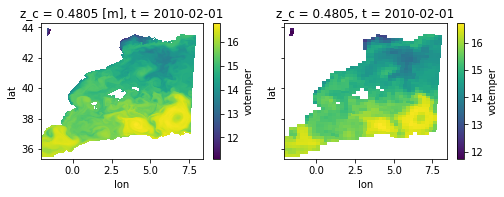

In [27]:
data_entity = data[4]

fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(8,2.5), sharex=True, sharey=True)
data_entity['HR_new_coords'].votemper.isel(z_c=0, t=0).plot(ax=ax[0], x='lon', y='lat')
data_entity['LR'].votemper.isel(z_c=0, t=0).plot(ax=ax[1], x='lon', y='lat')

In [28]:
data_entity['LR']

<xarray.Dataset>
Dimensions:          (y_c: 47, x_c: 40, y_r: 47, x_r: 40, t: 9, z_c: 107,
                      z_l: 107)
Coordinates: (12/30)
  * y_c              (y_c) int64 1 2 3 4 5 6 7 8 9 ... 40 41 42 43 44 45 46 47
  * x_c              (x_c) int64 1 2 3 4 5 6 7 8 9 ... 33 34 35 36 37 38 39 40
  * y_r              (y_r) float64 1.5 2.5 3.5 4.5 5.5 ... 44.5 45.5 46.5 47.5
  * x_r              (x_r) float64 1.5 2.5 3.5 4.5 5.5 ... 37.5 38.5 39.5 40.5
    lat              (y_c, x_c) float64 35.59 35.58 35.58 ... 43.77 43.76 43.74
    llat_cr          (y_c, x_r) float64 35.59 35.58 35.58 ... 43.76 43.75 43.74
    ...               ...
    area             (y_c, x_c) float64 5.031e+08 5.028e+08 ... 3.774e+08
  * z_c              (z_c) float32 0.4805 1.559 2.794 ... 968.4 985.3 1.002e+03
  * z_l              (z_l) float32 0.0 1.0 2.157 3.471 ... 960.0 976.9 993.8
  * t                (t) datetime64[ns] 2010-02-01 2010-02-11 ... 2010-04-22
    e3t              (z_c, y_c, x_c) float64 1.0 1.0 1.0 1.0 ... nan nan nan nan
    e3w              (z_l, y_c, x_c) float64 0.9218 0.9218 0.9218 ... nan nan
Data variables:
    vosaline         (t, z_c, y_c, x_c) float32 36.71 36.71 36.73 ... nan nan
    votemper         (t, z_c, y_c, x_c) float32 16.3 16.28 16.29 ... nan nan nan
    rho_true         (t, z_c, y_c, x_c) float64 1.027e+03 1.027e+03 ... nan nan
    sigma0_true      (t, z_c, y_c, x_c) float64 26.85 26.86 26.87 ... nan nan
    dx_p_true        (t, z_c, y_c, x_c) float64 -1.562e-08 1.415e-08 ... nan nan
    rho_true_sqr     (t, z_c, y_c, x_c) float64 1.054e+06 1.054e+06 ... nan nan
    sigma0_true_sqr  (t, z_c, y_c, x_c) float64 720.9 721.3 722.0 ... nan nan
    votemper_sqr     (t, z_c, y_c, x_c) float32 265.7 265.0 265.4 ... nan nan
    vosaline_sqr     (t, z_c, y_c, x_c) float32 1.347e+03 1.348e+03 ... nan nan

# Calculate LR variables

In [29]:
for data_entity in data :
    ds = data_entity['LR']
    ds['pressure'] = xr.apply_ufunc(gsw.conversions.p_from_z, -ds.z_c, ds.lat, dask='parallelized')
    # Compute density
    ds['rho_model'] = xr.apply_ufunc(gsw.density.rho, ds.vosaline, ds.votemper, ds.pressure, dask='parallelized')
    ds['sigma0_model'] = xr.apply_ufunc(gsw.density.sigma0, ds.vosaline, ds.votemper, dask='parallelized')
    
    ds['rho_delta'] = ds['rho_true'] - ds['rho_model']
    ds['sigma0_delta'] = ds['sigma0_true'] - ds['sigma0_model']
    
    grid = data_entity['LR_grid']
    for axis in ['X', 'Y'] :
        for variable in ['votemper', 'vosaline'] :
            ds['d'+axis+'_'+variable] = grid.derivative(ds[variable], axis=axis, boundary='extend')

# Vertical profiles of variables

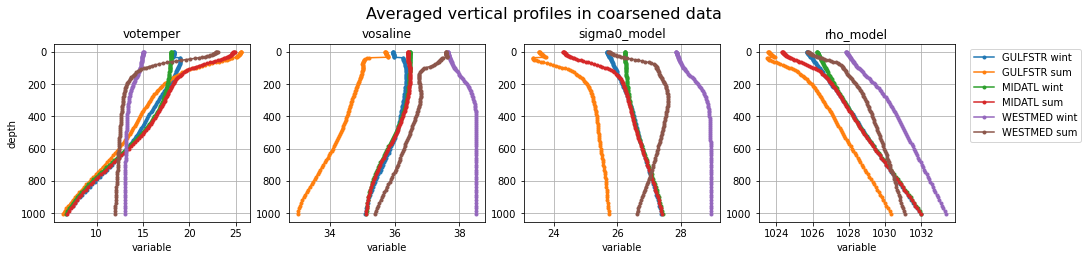

CPU times: user 1.27 s, sys: 205 ms, total: 1.48 s
Wall time: 1.13 s


In [49]:
%%time
fig, ax = plt.subplots(ncols=4, nrows=1, figsize=(15,3.5), constrained_layout=True)
fig.suptitle('Averaged vertical profiles in coarsened data', fontsize=16)
for i, variable in enumerate(['votemper', 'vosaline', 'sigma0_model', 'rho_model']) :
    for curve in range(len(data)) :
        variable_avg = data[curve]['LR'][variable].mean(['x_c', 'y_c', 't'])
        #variable_avg = (data[curve]['LR'][variable]-data[curve]['LR'][variable].isel(z_c=7)).mean(['x_c', 'y_c', 't'])
        normalisation = 1.
        (variable_avg/normalisation).plot(ax=ax[i], y='z_c', label=data[curve]['label'], marker='.')
    ax[i].set(title=variable, xlabel='variable', ylabel='', xscale='linear', yscale='linear')
    ax[i].grid(True)
    ax[i].invert_yaxis()
#ax[2].axvline(0.03, color='k')
ax[0].set(ylabel='depth')
ax[-1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

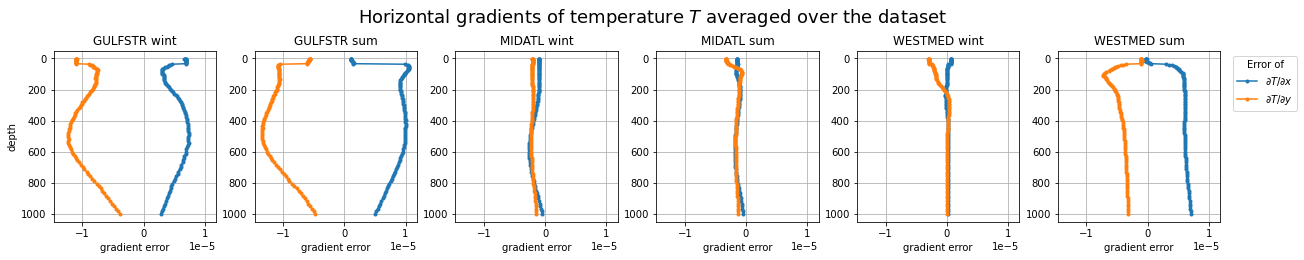

CPU times: user 974 ms, sys: 209 ms, total: 1.18 s
Wall time: 814 ms


In [42]:
%%time
fig, ax = plt.subplots(ncols=6, nrows=1, figsize=(18,3.5), constrained_layout=True, sharex=True)
fig.suptitle(r'Horizontal gradients of temperature $T$ averaged over the dataset', fontsize=18)
for col in range(len(data)) :
    data[col]['LR']['dX_votemper'].mean(['x_r', 'y_c', 't']).plot(ax=ax[col], y='z_c', color=line_colors[0], label=r'$\partial T/\partial x$', marker='.')
    data[col]['LR']['dY_votemper'].mean(['x_c', 'y_r', 't']).plot(ax=ax[col], y='z_c', color=line_colors[1], label=r'$\partial T/\partial y$', marker='.')
    ax[col].set(title=data[col]['label'], xlabel=r'gradient error', ylabel='', xscale='linear', yscale='linear')
    ax[col].grid(True)
    ax[col].invert_yaxis()
ax[0].set(ylabel='depth')
ax[-1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Error of')
plt.show()

# Subgrid variance

In [43]:
for data_entity in data :
    ds = data_entity['LR']
    for var in ['votemper', 'vosaline'] :
        ds[var+'_var'] = ds[var+'_sqr'] - ds[var]**2
    for var in ['sigma0', 'rho'] :
        ds[var+'_var'] = ds[var+'_true_sqr'] - ds[var+'_model']**2

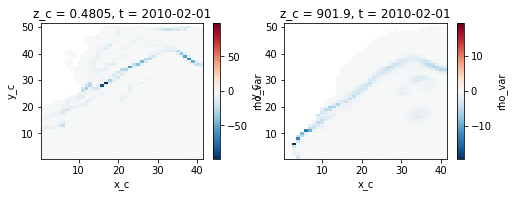

In [50]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(8,2.5))
data[0]['LR'].rho_var.isel(z_c=0, t=0).plot(ax=ax[0])
data[0]['LR'].rho_var.isel(z_c=100, t=0).plot(ax=ax[1])
plt.show()

## Vertical profiles

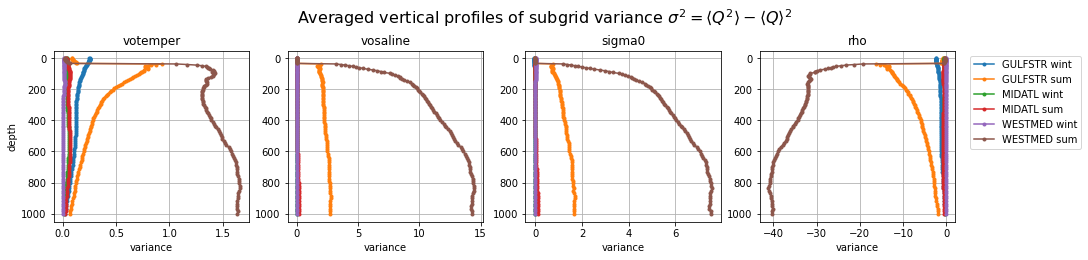

CPU times: user 899 ms, sys: 210 ms, total: 1.11 s
Wall time: 761 ms


In [52]:
%%time
fig, ax = plt.subplots(ncols=4, nrows=1, figsize=(15,3.5), constrained_layout=True)
fig.suptitle(r'Averaged vertical profiles of subgrid variance $\sigma^2 = \langle Q^2 \rangle - \langle Q \rangle^2$', fontsize=16)
for i, variable in enumerate(['votemper', 'vosaline', 'sigma0', 'rho']) :
    for curve in range(len(data)) :
        variance_avg = data[curve]['LR'][variable+'_var'].mean(['x_c', 'y_c', 't'])
        normalisation = 1.
        (variance_avg/normalisation).plot(ax=ax[i], y='z_c', label=data[curve]['label'], marker='.')
    ax[i].set(title=variable, xlabel='variance', ylabel='', xscale='linear', yscale='linear')
    ax[i].grid(True)
    ax[i].invert_yaxis()
ax[0].set(ylabel='depth')
ax[-1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

## Horizontal gradients

In [53]:
for data_entity in data :
    ds = data_entity['LR']
    grid = data_entity['LR_grid']
    for axis in ['X', 'Y'] :
        for variable in ['votemper', 'vosaline'] :
            ds['d'+axis+'_'+variable+'_var'] = grid.derivative(ds[variable+'_var'], axis=axis, boundary='extend')

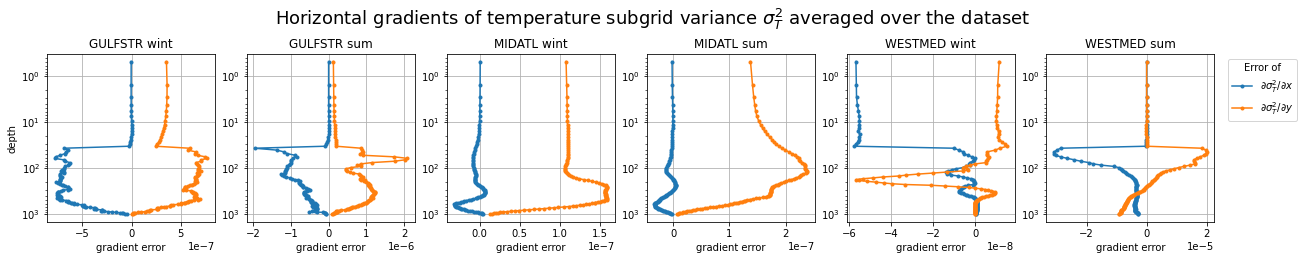

CPU times: user 2.2 s, sys: 279 ms, total: 2.48 s
Wall time: 2 s


In [54]:
%%time
fig, ax = plt.subplots(ncols=6, nrows=1, figsize=(18,3.5), constrained_layout=True, sharex=False)
fig.suptitle(r'Horizontal gradients of temperature subgrid variance $\sigma_T^2$ averaged over the dataset', fontsize=18)
for col in range(len(data)) :
    data[col]['LR']['dX_votemper_var'].mean(['x_r', 'y_c', 't']).plot(ax=ax[col], y='z_c', color=line_colors[0], label=r'$\partial \sigma_T^2/\partial x$', marker='.')
    data[col]['LR']['dY_votemper_var'].mean(['x_c', 'y_r', 't']).plot(ax=ax[col], y='z_c', color=line_colors[1], label=r'$\partial \sigma_T^2/\partial y$', marker='.')
    ax[col].set(title=data[col]['label'], xlabel=r'gradient error', ylabel='', xscale='linear', yscale='log')
    ax[col].grid(True)
    ax[col].invert_yaxis()
ax[0].set(ylabel='depth')
ax[-1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Error of')
plt.show()

# Density error

CPU times: user 73.3 ms, sys: 3.34 ms, total: 76.6 ms
Wall time: 72.6 ms


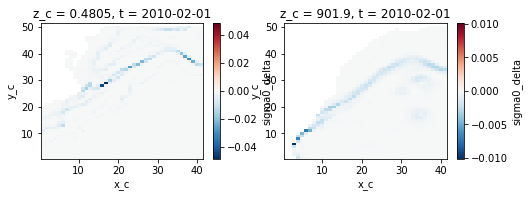

In [55]:
%%time
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(8,2.5))
data[0]['LR'].sigma0_delta.isel(z_c=0, t=0).plot(ax=ax[0])
data[0]['LR'].sigma0_delta.isel(z_c=100, t=0).plot(ax=ax[1])

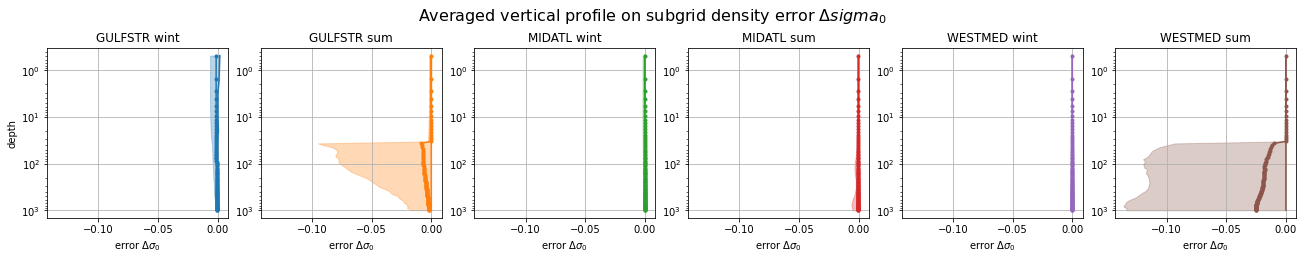

In [57]:
fig, ax = plt.subplots(ncols=6, nrows=1, figsize=(18,3.5), sharex=True, constrained_layout=True)
fig.suptitle(r'Averaged vertical profile on subgrid density error $\Delta sigma_0$', fontsize=16)
variable = 'sigma0_delta'
for index in range(len(data)) :
    mean_error = data[index]['LR'][variable].mean(['x_c', 'y_c', 't'])
    error_std = data[index]['LR'][variable].std(['x_c', 'y_c', 't'])
    max_error = data[index]['LR'][variable].max(['x_c', 'y_c', 't'])
    min_error = data[index]['LR'][variable].min(['x_c', 'y_c', 't'])
    
    mean_error.plot(ax=ax[index], y='z_c', marker='.', color=line_colors[index])
    max_error.plot(ax=ax[index], y='z_c', marker=None, color=line_colors[index])
    #min_error.plot(ax=ax[index], y='z_c', marker=None, color=line_colors[index])

    y = data[index]['LR']['z_c']
    x_l = mean_error - error_std
    x_r = xr.where(max_error>(mean_error + error_std), mean_error + error_std, max_error)
    ax[index].fill_betweenx(y, x_l, x_r, alpha=0.3, edgecolor=line_colors[index], facecolor=line_colors[index])
    ax[index].set(title=data[index]['label'], xlabel=r'error $\Delta \sigma_0$', ylabel='', xscale='linear', yscale='log')
    ax[index].grid(True)
    ax[index].invert_yaxis()
ax[0].set(ylabel='depth')
#ax[-1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

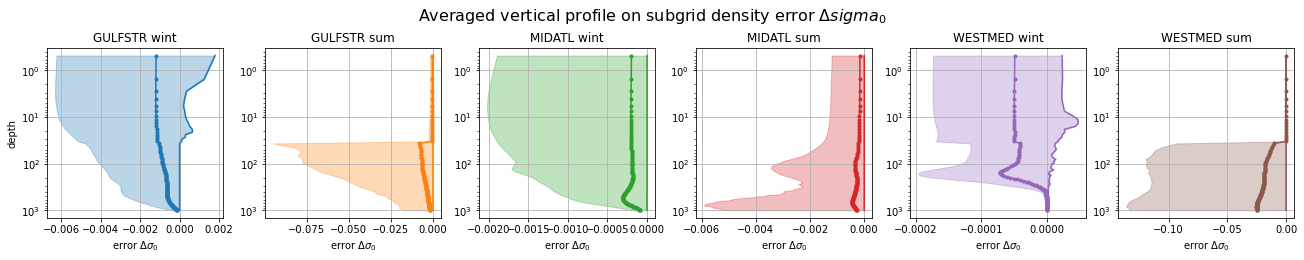

CPU times: user 2.28 s, sys: 279 ms, total: 2.55 s
Wall time: 2.08 s


In [59]:
%%time
fig, ax = plt.subplots(ncols=6, nrows=1, figsize=(18,3.5), sharex=False, constrained_layout=True)
fig.suptitle(r'Averaged vertical profile on subgrid density error $\Delta sigma_0$', fontsize=16)
variable = 'sigma0_delta'
for index in range(len(data)) :
    mean_error = data[index]['LR'][variable].mean(['x_c', 'y_c', 't'])
    error_std = data[index]['LR'][variable].std(['x_c', 'y_c', 't'])
    max_error = data[index]['LR'][variable].max(['x_c', 'y_c', 't'])
    mean_error.plot(ax=ax[index], y='z_c', marker='.', color=line_colors[index])
    max_error.plot(ax=ax[index], y='z_c', marker=None, color=line_colors[index])

    y = data[index]['LR']['z_c']
    x_l = mean_error - error_std
    x_r = xr.where(max_error>(mean_error + error_std), mean_error + error_std, max_error)
    ax[index].fill_betweenx(y, x_l, x_r, alpha=0.3, edgecolor=line_colors[index], facecolor=line_colors[index])
    ax[index].set(title=data[index]['label'], xlabel=r'error $\Delta \sigma_0$', ylabel='', xscale='linear', yscale='log')
    ax[index].grid(True)
    ax[index].invert_yaxis()
ax[0].set(ylabel='depth')
#ax[-1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Stratification profile (vertical derivative of density)

In [60]:
for data_entity in data :
    ds = data_entity['LR']
    ds['dz_rho_true'] = data_entity['LR_grid'].derivative(ds.rho_true, axis='Z', boundary='extend')
    ds['dz_rho_model'] = data_entity['LR_grid'].derivative(ds.rho_model, axis='Z', boundary='extend')
    ds['dz_sigma0_true'] = data_entity['LR_grid'].derivative(ds.sigma0_true, axis='Z', boundary='extend')
    ds['dz_sigma0_model'] = data_entity['LR_grid'].derivative(ds.sigma0_model, axis='Z', boundary='extend')

## Instanteneous at 1 point

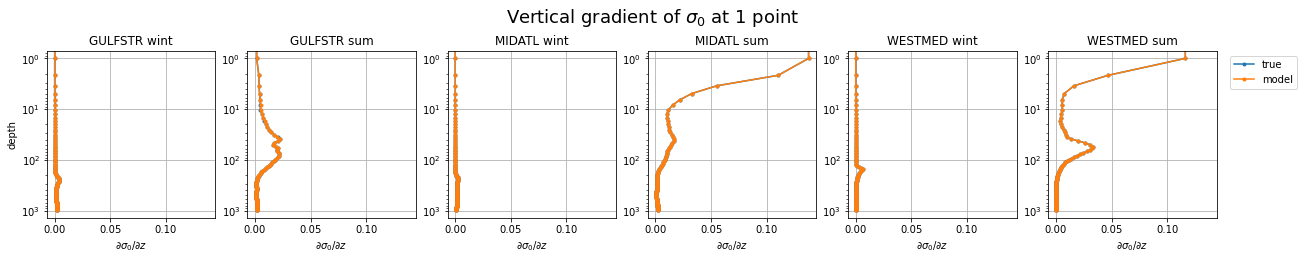

CPU times: user 2.43 s, sys: 260 ms, total: 2.69 s
Wall time: 2.22 s


In [63]:
%%time
fig, ax = plt.subplots(ncols=6, nrows=1, figsize=(18,3.5), constrained_layout=True, sharex=True)
fig.suptitle(r'Vertical gradient of $\sigma_0$ at 1 point', fontsize=18)
for col in range(len(data)) :
    (data[col]['LR']['dz_sigma0_true'].isel(x_c=30, y_c=30, t=0)).plot(ax=ax[col], y='z_l', label='true',marker='.')
    (data[col]['LR']['dz_sigma0_model'].isel(x_c=30, y_c=30, t=0)).plot(ax=ax[col], y='z_l', label='model',marker='.')
    ax[col].set(title=data[col]['label'], xlabel=r'$\partial \sigma_0/\partial z$', ylabel='', xscale='linear', yscale='log')
    ax[col].grid(True)
    ax[col].invert_yaxis()
ax[0].set(ylabel='depth')
ax[-1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

## Average over the dataset

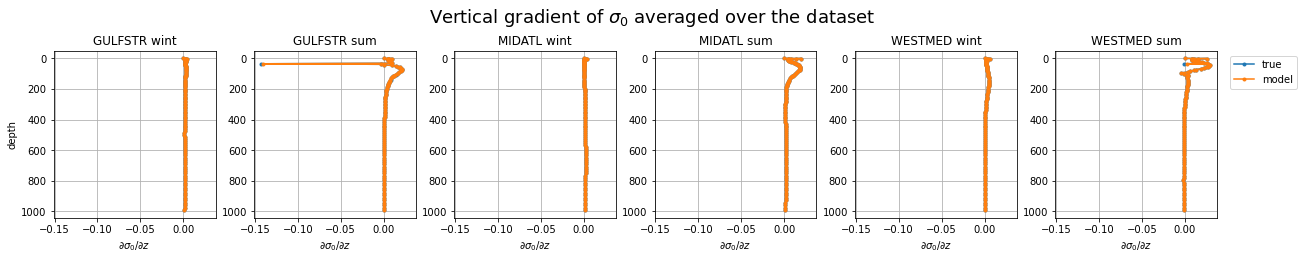

CPU times: user 995 ms, sys: 235 ms, total: 1.23 s
Wall time: 831 ms


In [62]:
%%time
fig, ax = plt.subplots(ncols=6, nrows=1, figsize=(18,3.5), constrained_layout=True, sharex=True)
fig.suptitle(r'Vertical gradient of $\sigma_0$ averaged over the dataset', fontsize=18)
for col in range(len(data)) :
    (data[col]['LR']['dz_sigma0_true'].mean(['x_c', 'y_c', 't'])).plot(ax=ax[col], y='z_l', label='true',marker='.')
    (data[col]['LR']['dz_sigma0_model'].mean(['x_c', 'y_c', 't'])).plot(ax=ax[col], y='z_l', label='model',marker='.')
    ax[col].set(title=data[col]['label'], xlabel=r'$\partial \sigma_0/\partial z$', ylabel='', xscale='linear')
    ax[col].grid(True)
    ax[col].invert_yaxis()
ax[0].set(ylabel='depth')
ax[-1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Horizontal gradients

In [64]:
for data_entity in data :
    ds = data_entity['LR']
    grid = data_entity['LR_grid']
    for axis in ['X', 'Y'] :
        for index in ['true', 'model'] :
            ds['d'+axis+'_rho_'+index] = grid.derivative(ds['rho_'+index], axis=axis, boundary='extend')
            ds['d'+axis+'_p_'+index] = g/rho_0*grid.cumint(grid.interp(ds['d'+axis+'_rho_'+index], axis=[axis, 'Z'], boundary='extend'), axis='Z')
            
        ds['d'+axis+'_rho_error'] = grid.derivative(ds['rho_delta'], axis=axis, boundary='extend')
        ds['d'+axis+'_p_error'] = g/rho_0*grid.cumint(grid.interp(ds['d'+axis+'_rho_error'], axis=[axis, 'Z'], boundary='extend'), axis='Z')

## Density error gradient

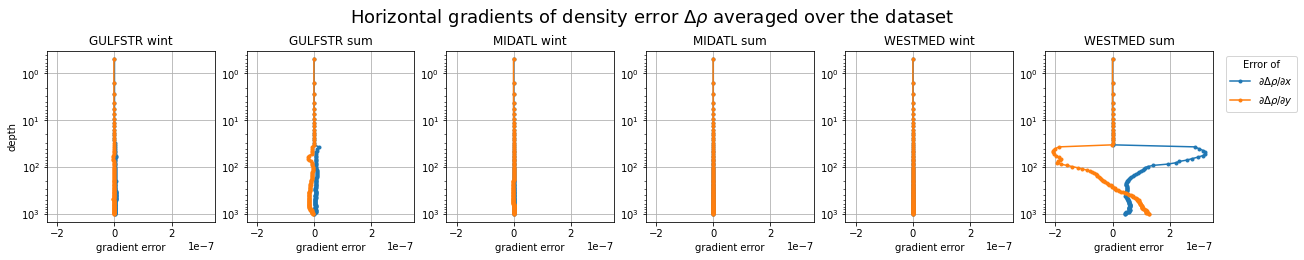

CPU times: user 2.22 s, sys: 266 ms, total: 2.49 s
Wall time: 2.01 s


In [65]:
%%time
fig, ax = plt.subplots(ncols=6, nrows=1, figsize=(18,3.5), constrained_layout=True, sharex=True)
fig.suptitle(r'Horizontal gradients of density error $\Delta \rho$ averaged over the dataset', fontsize=18)
for col in range(len(data)) :
    #(data[col]['LR']['dX_p_true']-data[col]['LR']['dX_p_model']).mean(['x_c', 'y_c', 't']).plot(ax=ax[col], y='z_c', label=r'$\partial p/\partial x$', marker='.', color=line_colors[0])
    data[col]['LR']['dX_rho_error'].mean(['x_r', 'y_c', 't']).plot(ax=ax[col], y='z_c', color=line_colors[0], \
                                                                   label=r'$\partial \Delta \rho/\partial x$', marker='.')
    
    #(data[col]['LR']['dY_p_true']-data[col]['LR']['dY_p_model']).mean(['x_c', 'y_c', 't']).plot(ax=ax[col], y='z_c', label=r'$\partial p/\partial y$', marker='.', color=line_colors[1])
    data[col]['LR']['dY_rho_error'].mean(['x_c', 'y_r', 't']).plot(ax=ax[col], y='z_c', color=line_colors[1], \
                                                                   label=r'$\partial \Delta \rho/\partial y$', marker='.', )
    ax[col].set(title=data[col]['label'], xlabel=r'gradient error', ylabel='', xscale='linear', yscale='log')
    ax[col].grid(True)
    ax[col].invert_yaxis()
ax[0].set(ylabel='depth')
ax[-1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Error of')
plt.show()

# Pressure gradient

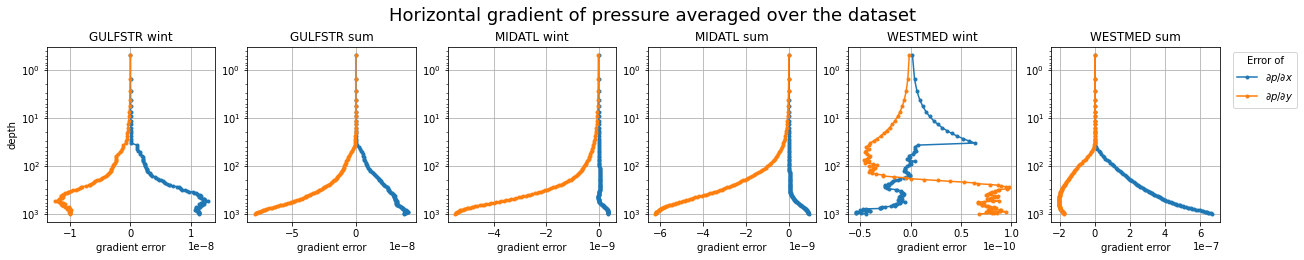

CPU times: user 2.16 s, sys: 266 ms, total: 2.42 s
Wall time: 1.95 s


In [66]:
%%time
fig, ax = plt.subplots(ncols=6, nrows=1, figsize=(18,3.5), constrained_layout=True, sharex=False)
fig.suptitle(r'Horizontal gradient of pressure averaged over the dataset', fontsize=18)
for col in range(len(data)) :
    #(data[col]['LR']['dX_p_true']-data[col]['LR']['dX_p_model']).mean(['x_c', 'y_c', 't']).plot(ax=ax[col], y='z_c', label=r'$\partial p/\partial x$', marker='.', color=line_colors[0])
    data[col]['LR']['dX_p_error'].mean(['x_c', 'y_c', 't']).plot(ax=ax[col], y='z_c', color=line_colors[0], \
                                                                 label=r'$\partial p/\partial x$', marker='.')
    
    #(data[col]['LR']['dY_p_true']-data[col]['LR']['dY_p_model']).mean(['x_c', 'y_c', 't']).plot(ax=ax[col], y='z_c', label=r'$\partial p/\partial y$', marker='.', color=line_colors[1])
    data[col]['LR']['dY_p_error'].mean(['x_c', 'y_c', 't']).plot(ax=ax[col], y='z_c', color=line_colors[1], \
                                                                 label=r'$\partial p/\partial y$', marker='.', )
    ax[col].set(title=data[col]['label'], xlabel=r'gradient error', ylabel='', xscale='linear', yscale='log')
    ax[col].grid(True)
    ax[col].invert_yaxis()
ax[0].set(ylabel='depth')
ax[-1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Error of')
plt.show()